# Analysis 과정 - Deep Learning

## RNN in Tensorflow

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from random import shuffle
import unipy as up

from unipy import aprint, lprint
from src.load_data import column_range_scaler, load_data
from src.utils import lprint, qprint, keras_lossplot, tf_predict_plot
print(tf.__version__)
print(os.getcwd())

print(up.__version__)

1.12.0
/home/jovyan/notebooks
0.1.22


In [3]:
data_dict = load_data()

train_x_rnn = data_dict['train_x_rnn']
train_y_rnn = data_dict['train_y_rnn']
test_x_rnn = data_dict['test_x_rnn']
test_y_rnn = data_dict['test_y_rnn']

_, INPUT_SEQ, INPUT_DIM = train_x_rnn.shape
_, OUTPUT_SEQ, OUTPUT_DIM =train_y_rnn.shape
NUM_UNITS = 4
BATCH_SIZE = 400
EPOCH_NUM = 30


Loading Data...
train_x_mlp : (4000, 3)
train_y_mlp : (4000, 2)
train_x_rnn : (4000, 5, 3)
train_y_rnn : (4000, 2, 2)
test_x_mlp : (289, 3)
test_y_mlp : (289, 2)
test_x_rnn : (284, 5, 3)
test_y_rnn : (284, 2, 2)
Complete.


## WHY RNN? (Sequence Data)

<img src="images/rnn_tf/Sequence_data.png" style="width:400px;height:70px;align:left;float:left;">



`Sequence Data` 는 이후의 데이터가 이전의 데이터의 영향을 받는다는 특징을 지님. <br>
이전 데이터의 영향을 받는 데이터도 함께 처리 가능한 기법이 `RNN(Recurrent Neural Network)` <br> 
RNN을 tensorflow로 구현하기 위해서는 **3단계(Build/Train/Predict)** 가 필요함.


<img src="images/rnn_tf/rnn_flow.gif">

## HOW RNN in tensorflow? (process with build/train/predict)

<img src='images/rnn_tf/rnn_arc.png' style='width:500px; height:200px;'>

## RNN Model

### RNN Build (function with 3 stage)


<img src="images/rnn_tf/rnn_vanishing_grad_thru_time.gif" width='45%' align='left'>  <img src="images/rnn_tf/rnn_vanishing_grad_thru_time.png" width='45%' align='right'>  

<div class='alert alert-block alert-success'>
<b> Example 1 : </b>
<br>

```py

def rnn_fn(
    num_units,
    input_x,
    
    ):
    
    # 1. rnn cell 생성
    
    # 2. rnn flow 생성
    
    # 3. rnn 예측값 생성
    
    # return 예측값

```
 
<br>
<br>
</div>
<br>


<div class='alert alert-block alert-success'>
<b> Example 2 : </b>
<br>

```py

def input_fn(
    input_x,
    input_y,
    ):
    
    # 1. input_x의 placeholder 생성
    
    # 2. input_y의 placeholder 생성
    
    # return input_x의 placeholder, input_y의 placeholder

```
 
<br>
<br>
</div>
<br>


<div class='alert alert-block alert-success'>
<b> Example 3 : </b>
<br>

```py

def optimize_fn(
    input_y,
    predictions,
    ):
    
    # 1. 실제 데이터와 예측값의 loss를 Mean_Squared_Error로 계산
    
    # 2. Adam Optimizer 생성
    
    # 3. Optimizer로 실제 데이터와 예측값의 오차를 최소화 training
    
    # return loss값, training operation

```
 
<br>
<br>
</div>
<br>


#### RNN flow



##### Cell 생성

<img src="images/rnn_tf/rnn_cell.png" style="width:500px;height:300px; align:right; float:right;">

<br><br>
* `num_units` 
* rnn cell 생성


In [4]:
tf.reset_default_graph()

rnn_cell = tf.contrib.rnn.BasicRNNCell(
    num_units=4,
)
print(rnn_cell)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


##### 생성된 cell 학습 및 구동 

* 1단계에서 생성한 cell과 input_x 값을 사용하여 `dynamic_rnn` 을 생성


In [5]:
outputs, _states = tf.nn.dynamic_rnn(
    rnn_cell,
    train_x_rnn,
    dtype=tf.float32,
)

##### projection layer

* 2단계에서 생성된 outputs을 projection layer를 통해 train_y의 shape에 맞는 predict_y 값을 생성

In [6]:
predict_y_rnn = tf.layers.dense(
    inputs=outputs,
    units=OUTPUT_DIM,
    kernel_initializer=tf.random_normal_initializer(0., .1),
    activation=tf.nn.tanh,
)

##### RNN_flow_function

In [7]:
def rnn_fn(
    num_units,
    input_x,
    
    ):
    
    # 1. rnn cell 생성
    rnn_cell = tf.contrib.rnn.BasicRNNCell(
        num_units=num_units,
    )
    
    # 2. rnn flow 생성
    outputs,_state = tf.nn.dynamic_rnn(
        cell=rnn_cell,
        inputs=input_x,
        dtype=tf.float32,
    )
    
    # 3. 예측값 생성
    predict_y = tf.layers.dense(
        inputs=outputs[:, -2:, :],
        units=2,
        use_bias=True,
        kernel_initializer=tf.random_normal_initializer(0., .1),
        activation=tf.nn.tanh,
        name='predict_y'
    )
    
    # return 예측값
    return predict_y

#### Input
* **Batch size**<br>

 
* **Sequence length**<br>
    -30분 데이터가 5분 단위로 있다면, Sequence Length = 6<br>


* **Input/Output dimension**<br>
    -Input/Output KPI 크기 <br>
    
    
    
* **Input y**<br>
    -예측하고자 하는 값의 실제 값

<img src='images/rnn_tf/rnn_input2.png'>

In [8]:
def input_fn(
    input_x,
    input_y,
    ):
    
    _, x_seq_length, x_dim = input_x.shape
    _, y_seq_length, y_dim = input_y.shape
    
    # 1. input_x의 placeholder 생성
    input_x_placeholder = tf.placeholder(
        tf.float32,
        shape=[None, x_seq_length, x_dim],
        name='input_x_placeholder'
    )
    
    # 2. input_y의 placeholder 생성
    input_y_placeholder = tf.placeholder(
        tf.float32,
        shape=[None, y_seq_length, y_dim],
        name='input_y_placeholder'
    )
    
    # return input_x의 placeholder, input_y의 placeholder
    return input_x_placeholder, input_y_placeholder

#### Optimization

<img src='images/rnn_tf/rnn_loss.png' style="width:380px;height:380px;align:right;float:right;">
<br>
<br>
<br>

__**loss function **__ <br>

`Cost Function` 혹은 `Objective Function`으로도 불린다.  
예측값과 실제값의 차이를 `Error` 또는 `Cost`라고 부르는데 이 `Error`의 측정방법이 곧 `Loss Function`이다.  
'모델이 학습한다'는 의미는, <font color='#318CE7'> <b><i>이 값을 최소화 하는 방향으로 $w$ 와 $b$ 를 업데이트 한다는 뜻이다. </i></b></font>  

__**optimization**__ 

함수의 극대값 또는 극소값을 구하기 위해 현재 위치에서 함수값의 변화가 가장 큰 방향으로 이동한다.
함수값의 변화가 가장 큰 방향을 구할 수만 있다면 다양한 문제에 똑같은 개념을 적용할 수 있다.



In [9]:
def optimize_fn(
    input_y,
    predictions,
    ):
    
    # 1. 실제 데이터와 예측값의 loss를 Mean_Squared_Error로 계산    
    loss = tf.losses.mean_squared_error(
        labels=input_y,
        predictions=predictions,
    )
    
    # 2. Adam Optimizer 생성    
    optimizer = tf.train.AdamOptimizer(
        learning_rate=0.001,
    )
    
    # 3. Optimizer로 실제 데이터와 예측값의 오차를 최소화 training
    train_op = optimizer.minimize(loss)
    
    # return loss값, training operation    
    return train_op, loss

#### Final

In [10]:
def build_rnn_fn(
    input_x,
    input_y,
    num_units,    
    ):
    
    
    tf.reset_default_graph()
    
    #===== Essential ========================================================#
    
    
    # 1. input_fn
    input_x_placeholder, input_y_placeholder = input_fn(
        input_x,
        input_y,
    )
    
    # 2. rnn_fn
    predict_y = rnn_fn(
        num_units,
        input_x_placeholder,
    )
    
    # 3. optimize_fn
    train_op, loss_op = optimize_fn(
        input_y_placeholder,
        predict_y,
    )
    
    #========================================================================#

    init_op = tf.global_variables_initializer()
    
    return input_x_placeholder, input_y_placeholder, predict_y, init_op, train_op, loss_op
    
    

### RNN Training

<img src='images/rnn_tf/rnn_arc_train.png' style='width:500px; height:200px;'>

In [11]:
def train_fn(
    input_x,
    input_y,
    input_x_placeholder,
    input_y_placeholder,
    batch_size,
    epoch_num,
    init_op,
    train_op,
    loss_op,
    sess=None,
    ):
    
    sess.run(init_op)

    for epoch in range(epoch_num):

        data_cnt = input_x.shape[0]
        batch_num = int(data_cnt / batch_size)
        
        
        batched_x = up.splitter(input_x, how='remaining', size=128)
        batched_y = up.splitter(input_y, how='remaining', size=128)

        idx_list = np.arange(len(batched_x))
        shuffle(idx_list)

        for i in idx_list:
            sess.run(
                train_op,
                feed_dict={
                    input_x_placeholder: batched_x[i],
                    input_y_placeholder: batched_y[i],
                },
            )

        if epoch % 10 == 0:
            loss_value = sess.run(
                loss_op,
                feed_dict={
                    input_x_placeholder: batched_x[i],
                    input_y_placeholder: batched_y[i],
                },
            )
            print("LOSS at %d: %.5f" %(epoch, loss_value))

    print(f'Training Complete : LOSS at {loss_value:.5f}')
 


In [12]:
rnn_x_placeholder, rnn_y_placeholder, predict_y_rnn, rnn_init_op, rnn_train_op, rnn_loss_op = build_rnn_fn(
    train_x_rnn,
    train_y_rnn,
    num_units=4,
)


with tf.Session() as sess:
    
    train_fn(
        train_x_rnn,
        train_y_rnn,
        rnn_x_placeholder,
        rnn_y_placeholder,
        batch_size=64,
        epoch_num=10,
        init_op=rnn_init_op,
        train_op=rnn_train_op,
        loss_op=rnn_loss_op,
        sess=sess,
    )
    

LOSS at 0: 0.16017
Training Complete : LOSS at 0.16017


### RNN Prediction (Inference)

<img src='images/rnn_tf/rnn_arc_pred.png' style='width:500px; height:200px;'>

In [13]:
def predict_fn(
        input_x,
        input_y,
        input_x_placeholder,
        input_y_placeholder,
        predict_y,
        sess=None,
    ):
    
    predict = sess.run(
        predict_y,
        feed_dict={
            input_x_placeholder: input_x,
            input_y_placeholder: input_y,
        },
    )
    
    return predict

LOSS at 0: 0.45020
Training Complete : LOSS at 0.45020


/opt/conda/envs/tf-py36/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


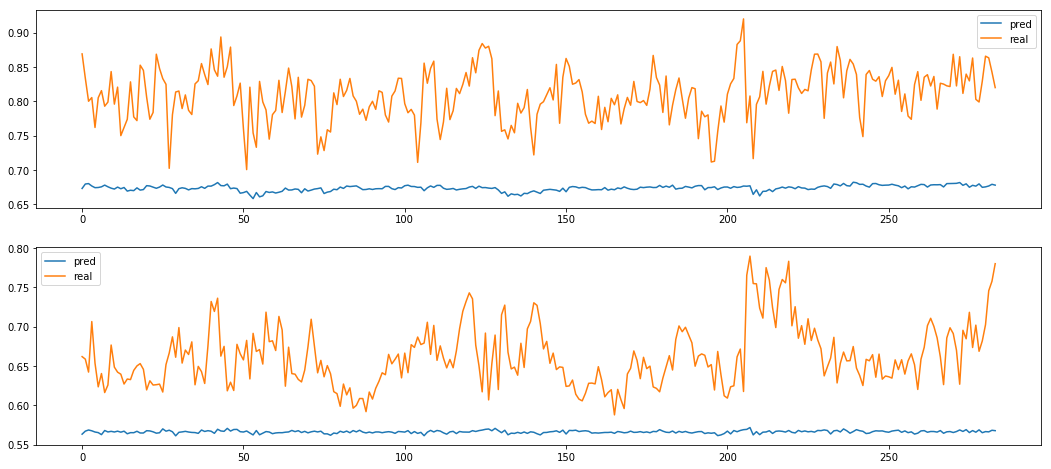

In [14]:
rnn_x_placeholder, rnn_y_placeholder, predict_y_rnn, rnn_init_op, rnn_train_op, rnn_loss_op = build_rnn_fn(
    train_x_rnn,
    train_y_rnn,
    num_units=4,
)


with tf.Session() as sess:
  
    train_fn(
        train_x_rnn,
        train_y_rnn,
        rnn_x_placeholder,
        rnn_y_placeholder,
        batch_size=64,
        epoch_num=10,
        init_op=rnn_init_op,
        train_op=rnn_train_op,
        loss_op=rnn_loss_op,
        sess=sess,
    )
    
    
    predict_y_rnn = predict_fn(
        test_x_rnn,
        test_y_rnn,
        rnn_x_placeholder,
        rnn_y_placeholder,
        predict_y_rnn,
        sess=sess,
    )
    
    tf_predict_plot(
        test_y_rnn,
        predict_y_rnn,
        method='rnn',
    )
        

## bi-RNN Model


기존 `RNN Model`은 시계열 데이터의 현재 시간 이전 정보만을 고려하여 학습시킨 방법.<br>
현재 시간 이전 정보 뿐만이 아니라, 이후 정보까지 저장한 모델이 `Bidirectional RNN`. <br>
시간의 순방향을 따르는 RNN과 역방향을 따르는 RNN을 각각 두고, 두 RNN의 출력을 합쳐 하나로 출력함.



<img src="images/rnn_tf/rnn_bidirectional_flow.gif" width='45%' align='left'>  
<img src="images/rnn_tf/rnn_bidirectional_flow.png" width='45%' align='right'>  

<div class='alert alert-block alert-success'>
<b> Example : </b>
<br>

```py

def birnn_fn(
    num_units,
    input_x,
    
    ):
    
    # 1. birnn cell 생성
    
    # 2. bidirectional rnn flow 생성
    
    # 3. bidirectional rnn 예측값 생성
    
    # return 예측값

```
 
<br>
<br>
</div>
<br>

### biRNN Build

In [15]:
def birnn_fn(
    num_units,
    input_x,
    output_dim,
    
    ):
    
    # 1. birnn cell 생성
    rnn_forward_cell = tf.nn.rnn_cell.BasicRNNCell(
        num_units,
        name='forward_rnn_cell',
    )
    
    rnn_backward_cell = tf.nn.rnn_cell.BasicRNNCell(
        num_units,
        name='backward_rnn_cell',
    )

    # 2. bidirectional rnn flow 생성
    (outputs_fw, outputs_bw), _state = tf.nn.bidirectional_dynamic_rnn(
        cell_fw=rnn_forward_cell,
        cell_bw=rnn_backward_cell,
        inputs=input_x,
        dtype=tf.float32,
    )
    
    #add_outputs = tf.reduce_sum(outputs, axis=-1)
    add_outputs = outputs_fw + outputs_bw
    print(outputs_fw.shape)
    print(outputs_bw.shape)
    print(add_outputs.shape)

    # 3. bidirectional rnn 예측값 생성 
    predict_y = tf.layers.dense(
        inputs=add_outputs[:, -2:, :],
        units=output_dim,
        use_bias=True,
        kernel_initializer=tf.random_normal_initializer(0., .1),
        activation=tf.nn.tanh,
        name='predict_y'
    )
    
    # return 예측값 
    return predict_y


In [16]:
def build_birnn_fn(
    input_x,
    input_y,
    num_units,    
    ):
    
    tf.reset_default_graph()
    
    
    #===== Essential ========================================================#
    
    # 1. input_fn
    input_x_placeholder, input_y_placeholder = input_fn(
        input_x,
        input_y,
    )
    
    # 2. birnn_fn
    predict_y = birnn_fn(
        num_units,
        input_x_placeholder,
        output_dim=2,
    )
    
    # 3. optimize_fn
    train_op, loss_op = optimize_fn(
        input_y_placeholder,
        predict_y,
    )
    
    #========================================================================#

    
    init_op = tf.global_variables_initializer()
    
    return input_x_placeholder, input_y_placeholder, predict_y, init_op, train_op, loss_op
    
 

### biRNN Training

In [17]:
(birnn_x_placeholder, birnn_y_placeholder,
     predict_y_rnn,
     rnn_init_op, rnn_train_op, rnn_loss_op) = build_birnn_fn(
    train_x_rnn,
    train_y_rnn,
    num_units=4,
)



with tf.Session() as sess:
    
    train_fn(
        train_x_rnn,
        train_y_rnn,
        birnn_x_placeholder,
        birnn_y_placeholder,
        batch_size=64,
        epoch_num=10,
        init_op=rnn_init_op,
        train_op=rnn_train_op,
        loss_op=rnn_loss_op,
        sess=sess,
    )
    

(?, 5, 4)
(?, 5, 4)
(?, 5, 4)
LOSS at 0: 0.27421
Training Complete : LOSS at 0.27421


### biRNN Prediction (Inference)

(?, 5, 4)
(?, 5, 4)
(?, 5, 4)
LOSS at 0: 0.16913
Training Complete : LOSS at 0.16913


/opt/conda/envs/tf-py36/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


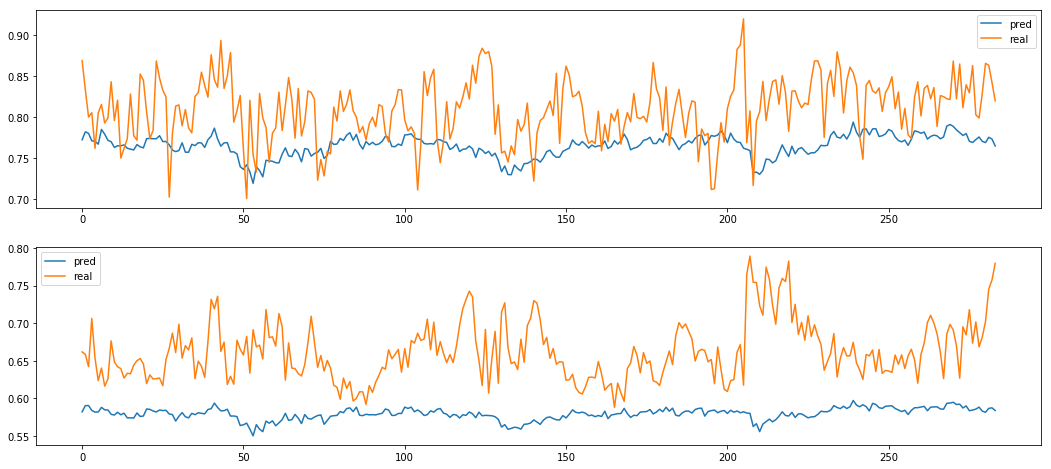

In [18]:
(birnn_x_placeholder, birnn_y_placeholder,
     predict_y_rnn,
     rnn_init_op, rnn_train_op, rnn_loss_op) = build_birnn_fn(
    train_x_rnn,
    train_y_rnn,
    num_units=4,
)



with tf.Session() as sess:
    
    train_fn(
        train_x_rnn,
        train_y_rnn,
        birnn_x_placeholder,
        birnn_y_placeholder,
        batch_size=64,
        epoch_num=10,
        init_op=rnn_init_op,
        train_op=rnn_train_op,
        loss_op=rnn_loss_op,
        sess=sess,
    )
    
    predict_y_rnn = predict_fn(
        test_x_rnn,
        test_y_rnn,
        birnn_x_placeholder,
        birnn_y_placeholder,
        predict_y_rnn,
        sess=sess,
    )
        

    tf_predict_plot(
        test_y_rnn,
        predict_y_rnn,
        method='rnn',
    )